## 1. Configuración

---


### Instalación de las librerias unthermal y unmotor

Descomentar y ejecutar esta celda solo para instalar por primera vez o actualizar las librerias. __Asegúrese de instalar  [Git](https://git-scm.com/download/win/ "Git").__



In [1]:
import subprocess
command = ["pip", "install", "-I", "git+https://github.com/nebisman/UNThermal.git@main#subdirectory=code/python_code"]
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line.strip())

command = ["pip", "install", "-I", "git+https://github.com/nebisman/UNDCMotor.git@main#subdirectory=code/python_code"]
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
for line in process.stdout:
    print(line.strip())

Cloning https://github.com/nebisman/UNThermal.git (to revision main) to /tmp/pip-req-build-sf6wzyoz
Running command git clone --filter=blob:none --quiet https://github.com/nebisman/UNThermal.git /tmp/pip-req-build-sf6wzyoz
Resolved https://github.com/nebisman/UNThermal.git to commit d444cf905b9f2d42073f686bba672f9554b9c460
Installing build dependencies: started
Installing build dependencies: finished with status 'done'
Getting requirements to build wheel: started
Getting requirements to build wheel: finished with status 'done'
Preparing metadata (pyproject.toml): started
Preparing metadata (pyproject.toml): finished with status 'done'
Using cached iottalk_paho_mqtt-1.5.1-py3-none-any.whl.metadata (46 kB)
Using cached control-0.10.1-py3-none-any.whl.metadata (7.6 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached matplotlib-3.9.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached sci


### Importación de comandos de la libreria unthermal y unmotor

A continuación importamos los comandos básicos que usaremos de la libreria `unthermal` y la libreria `Matplotlib` para las figuras.

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import unthermal as temp
import unmotor as motor


### Definición de los sistemas en el IoT

Lo primero que necesitamos es definir tanto el sistema térmico como el motor en el IoT

In [27]:
mi_termico = temp.ThermalSystemIoT(plant_number = "THERMAL_LEO" , broker_address = "192.168.0.11", port=1883)
mi_motor = motor.MotorSystemIoT(plant_number = "MOTORLEO" , broker_address = "192.168.0.11", port=1883) 



Successfully connected to MQTT Broker 192.168.1.100
Command send:  1
PID parameters changed
Successfully connected to MQTT Broker 192.168.1.100
Subscribed:  2   (2,)
Command send:  3


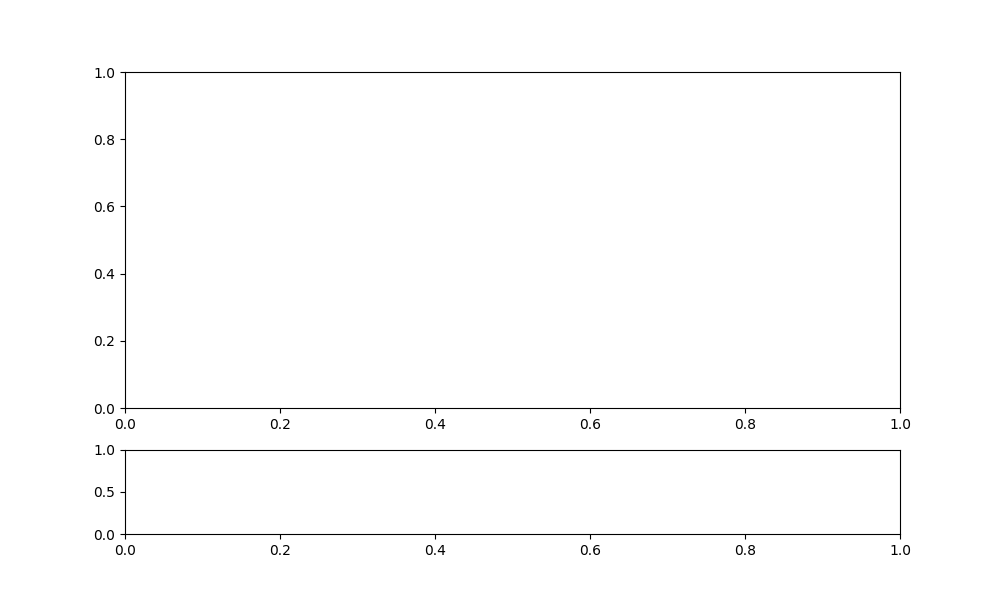

TimeoutError: The connection has been lost. Please try again

In [3]:
# Reglas de Ziegler - Nichols para un controlador PI

# estos son los parámetros del modelo que obtuvimos en nuestro experimento
alfa = 1.36
tau = 35.89
L = 0.54

# Calculamos las constantes según el método de Ziegler-Nichols

kp_zn = 0.9*tau / (alfa * L)  # constante proporcional
ki_zn = 0.3*tau / (alfa * L**2) # constante integral 

# programamos los parámetros del PID con el siguiente comando
temp.set_pid(mi_termico,kp=kp_zn, ki=ki_zn, kd=0, beta=1)

# Ahora obtenemos la respuesta al escalón 

r0 = 50 # valor inicial del escalón de referencia antes del cambio (grados celsius)
t0 = 60 # tiempo que dura en el valor inicial

r1 = 60 # valor final del escalón de referencia  (grados celsius)
t1 = 60 # tiempo que demora en el valor final

# con este comando obtenemos la respuesta al escalón
t_zn, r_zn, y_zn, u_zn = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1)

In [4]:
mi_motor = motor.MotorSystemIoT(plant_number = "MOTORLEO" , broker_address = "192.168.0.11", port=1883) 

Starting experiment, please wait...
Connected successfully to MQTT Broker!
Subscribed:  1   (2,)


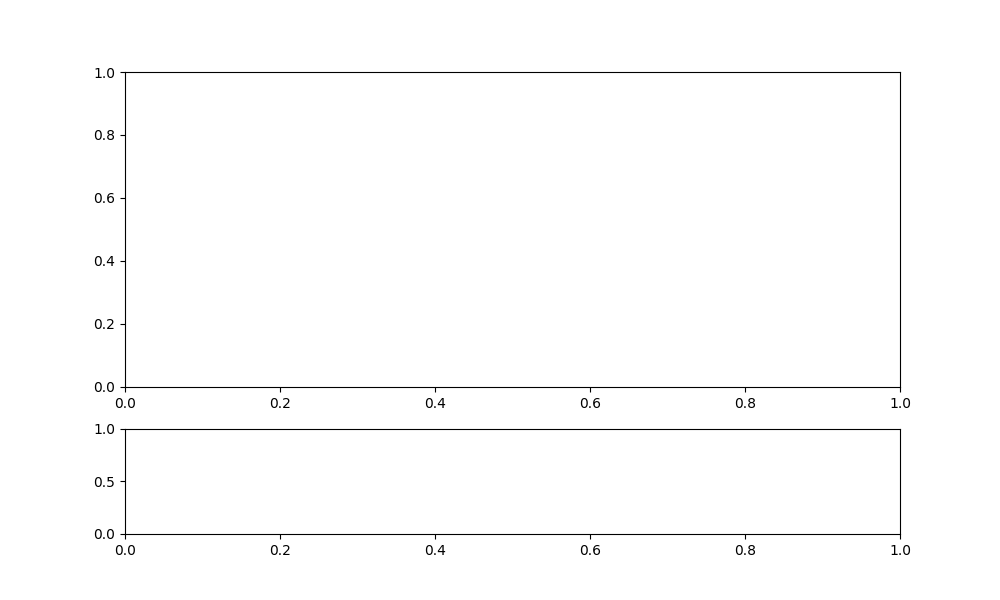

Starting optimization for first order model...
	 Initial cost function: 407.24
	 Final cost function: 366.99
alpha=504.30 	 tau1=0.235


Starting optimization for second order model...
	 Initial cost function: 406.28
	 Final cost function: 255.46
alpha=467.83 	 tau1=0.181 	 tau2=0.027


(TransferFunction(array([504.30233587]), array([0.23466866, 1.        ])),
 TransferFunction(array([467.83363431]), array([0.00494519, 0.20867557, 1.        ])))

In [5]:
## Modelo del motor

#alfa, tau, L = motor.get_fomodel_step(mi_motor, yop = 150)

motor.get_models_prbs(mi_motor, yop=360)

In [3]:
# metodo iterativo pasos 1 y 2


alfa =504
tau= 0.23
SP = 10 
tee=.5
tr=0.2
zeta = np.abs(np.log(SP/100))/np.sqrt(np.pi**2 + (np.log(SP/100))**2) 
w1 = 4.5/(zeta*tee)
w2 = 2.5/tr
print(w1,w2)
I = [1/(2*zeta*tau), 0.25/0.02]
print(I)
print(zeta)


15.224432653755716 12.5
[np.float64(3.6773991917284334), 12.5]
0.5911550337988976


0.0069375 0.06035218253968254
Connected successfully to MQTT Broker!
succesfull change of PID parameters
Connected successfully to MQTT Broker!
Subscribed:  62   (2,)


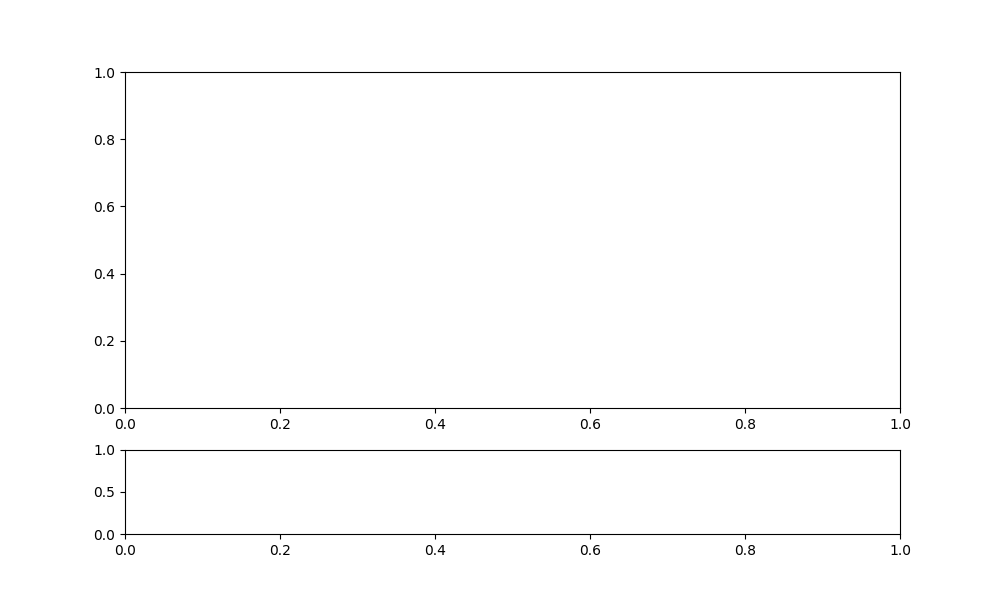

In [24]:
# metodo iterativo pasos 3 ---
SP = 10 
tee=.5
tr=0.2

wn = 11.5
zeta = 0.85
kp = (2*zeta*wn*tau - 1)/alfa
ki = wn**2*tau / alfa
r0 = 0
r1 = 360
t0= 1
t1=2
deltar= r1-r0


def draw_specifications(tee,tr, SP):
    fig=plt.gcf()
    ay, au = fig.get_axes()
    delta_r = r1 - r0

    # tee specification
    ay.axvline(tee+t0, color='#0080668F', linestyle='--', linewidth=1.25)
    ay.text(t0 +tee + t1/50 , r0 + 0.1*delta_r, "$t_{ee}$", fontsize=14, color='#008066FF')

    # tr specification
    ay.plot([t0, t0+ tr, t0+ tr], [r0 + 0.9*delta_r, r0 + 0.9*delta_r, r0 - 0.1*delta_r],  color='#917c6fff', linestyle='--',linewidth=1.25)
    ay.text(t0 + tr + t1/50 , r0 + 0.1*delta_r, "$t_{r}$", fontsize=14,  color='#917c6fff')

    # SP specification
    ay.axhline(r1 + SP * delta_r /100, color='#d42affff', linestyle='--', linewidth=1.25)
    ay.text(0.8* t0 , r1 + (SP/100 + 0.025 ) * delta_r, "$SP$", fontsize=14, color='#d42affff')

print(kp, ki)

motor.set_pid(mi_motor,kp=kp,ki=ki,kd=0,beta=1, output="speed", deadzone=0)
t, r, y, u = motor.step_closed(mi_motor,r0=0, r1=360, t0=t0, t1=t1);
draw_specifications(tee, tr, SP)





+ Hacerlo con sobrepico del 10%
+ Hacerlo con sobrepico del 5%
+ Hacerlo sin sobrepico


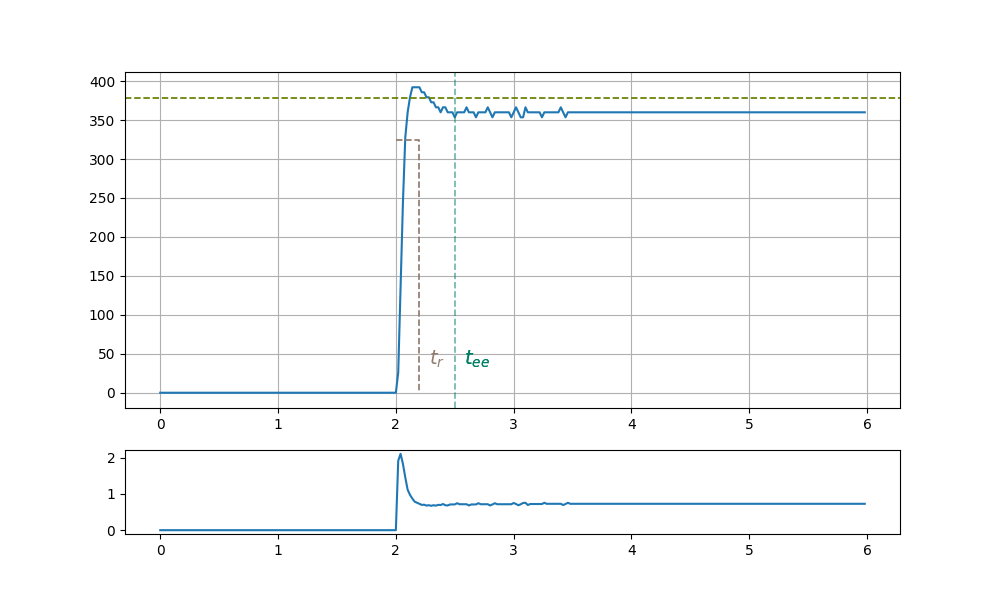

In [61]:
fig, (ay, au) = plt.subplots(2, 1, figsize=(10, 6),height_ratios=[4, 1])
ay.plot(t,y)
au.plot(t,u)
ay.grid(True)
delta_r = r1 - r0

# tee specification
ay.axvline(tee+t0, color='#0080668F', linestyle='--', linewidth=1.25)
ay.text(t0 +tee + t1/50 , r0 + 0.1*delta_r, "$t_{ee}$", fontsize=14, color='#008066FF')

# tr specification
ay.plot([t0, t0+ tr, t0+ tr], [r0 + 0.9*delta_r, r0 + 0.9*delta_r, 0],  color='#917c6fff', linestyle='--',linewidth=1.25)
ay.text(t0 + tr + t1/50 , r0 + 0.1*delta_r, "$t_{r}$", fontsize=14,  color='#917c6fff')

# SP specification
ay.axhline(r1 + SP * delta_r /100, color='#668000ff', linestyle='--', linewidth=1.25)
ay.text(t0 +tee + t1/50 , r0 + 0.1*delta_r, "$t_{ee}$", fontsize=14, color='#008066FF')


plt.show()

In [2]:
mi_termico = temp.ThermalSystemIoT(plant_number = "THERMAL_LEO" , broker_address = "192.168.0.11", port=1883) 


In [29]:
# metodo iterativo pasos 1 y 2
tau =36.98
alfa =1.18
Te = 0.8
SP = 5 
tee=30
tr=20
zeta = np.abs(np.log(SP/100))/np.sqrt(np.pi**2 + (np.log(SP/100))**2) 
w1 = 4.5/(zeta*tee)
w2 = 2.5/tr
print(w1,w2)
I = [1/(2*zeta*tau), 0.25/Te]
print(I,w1,w2)
print(zeta)




0.21735768303305555 0.125
[np.float64(0.019592363713093166), 0.3125] 0.21735768303305555 0.125
0.6901067305598217


18.54353813559322 3.060447563559322
Successfully connected to MQTT Broker 192.168.0.11
Command send:  48
PID parameters changed
Successfully connected to MQTT Broker 192.168.0.11
Subscribed:  1   (2,)
Command send:  2


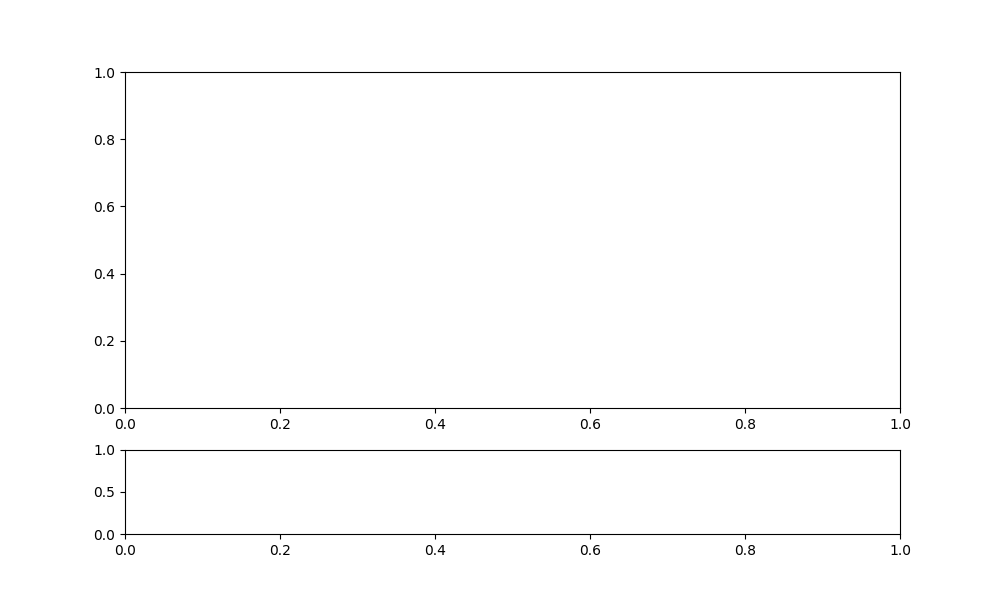

In [47]:
# metodo iterativo pasos 3 ---
wn = 0.3125
zeta = .99
kp = (2*zeta*wn*tau - 1)/alfa
ki = wn**2*tau / alfa
r0 = 60
r1 = 70
t0= 50
t1= 50
deltar= r1-r0
print(kp , ki)

temp.set_pid(mi_termico,kp=kp,ki=ki,kd=0,beta=1)
t_values = [0, 40, 80, 120, 160, 200]
r_values = [40, 70, 55, 55, 45, 70 ]
temp.profile_closed(my_system, timevalues=t_values , refvalues=r_values);
plt.savefig("profile_response.svg", format="svg", bbox_inches="tight") # para salvar la figura
# t, r, y, u = temp.step_closed(mi_termico,r0=r0, r1=r1, t0=t0, t1=t1);
# draw_specifications(tee, tr, SP)

Successfully connected to MQTT Broker 192.168.0.11


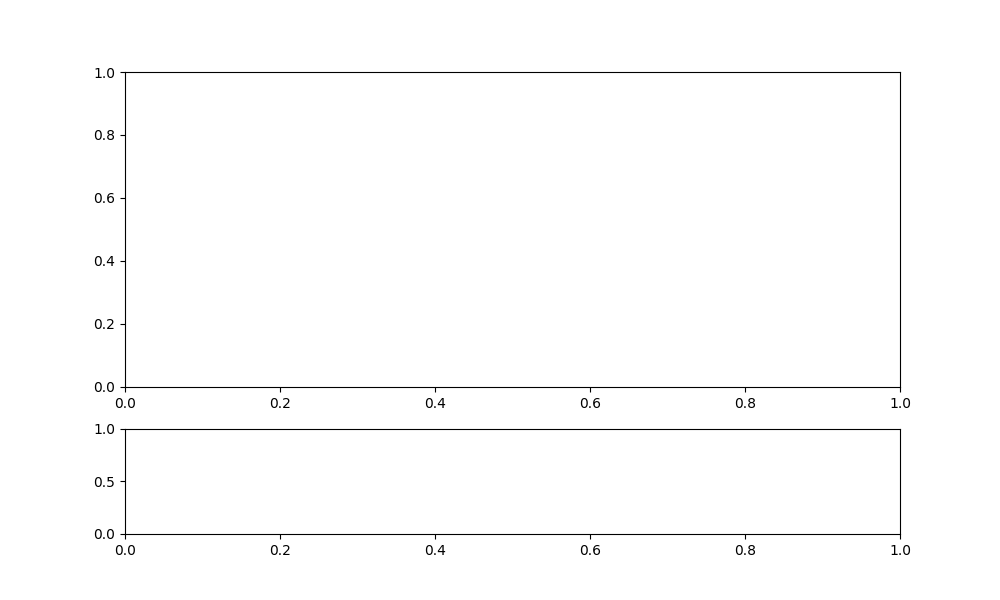

Subscribed:  3   (2,)
Command send:  4
PBRS experiment completed

Starting optimization for first order model...
	 Initial cost function: 26.14
	 Final cost function: 6.31
alpha=1.05 	 tau1=32.203


Starting optimization for second order model...
	 Initial cost function: 29.40
	 Final cost function: 5.96
alpha=1.03 	 tau1=31.123 	 tau2=0.555

FO model: G1=1.05/(32.20 s + 1)
FOTD model: G2=1.03 * exp(-0.55) /(31.12 s + 1)


(TransferFunction(array([1.04814914]), array([32.20348219,  1.        ])),
 TransferFunction(array([1.03333189]), array([31.12320989,  1.        ])),
 np.float64(0.554960059492347))

In [4]:
temp.get_models_prbs(mi_termico, yop=70)



In [6]:
plt.savefig("prbs_response.svg", format="svg", bbox_inches="tight") 
plt.savefig("prbs_response.png", format="png", bbox_inches="tight") 

0.16105186855670103 0.8819507087628866 0.010929982817869418
Connected successfully to MQTT Broker!
succesfull change of PID parameters
Connected successfully to MQTT Broker!


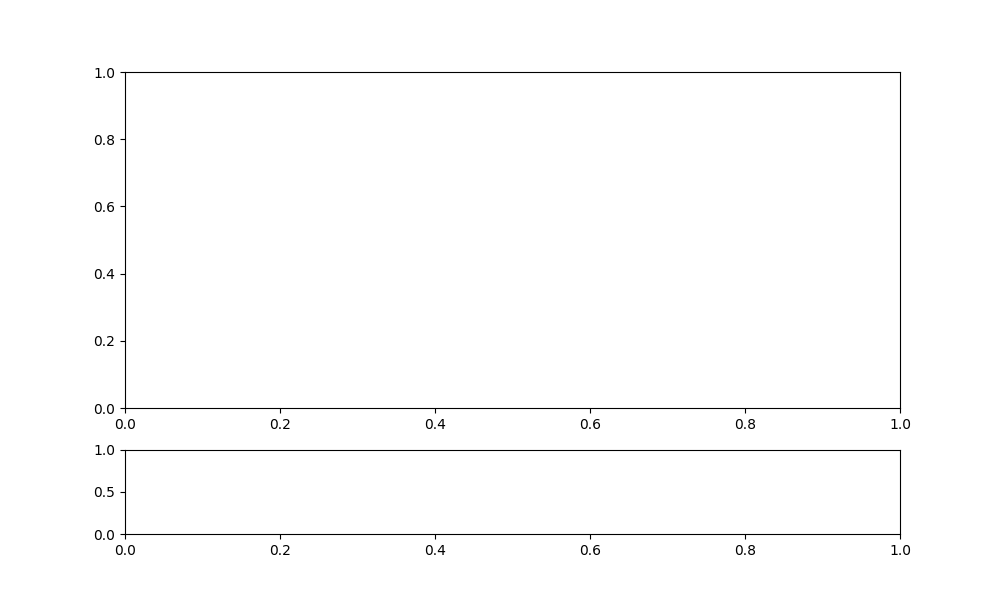

Subscribed:  65   (2,)


In [25]:
# pid

wn = 11.5
zita = .8
alfa = 931.2
tau=0.27
n=2
kp = wn**2*(2*zita*n+1)*tau/alfa
ki = n * tau* wn**3 / alfa
kd = (tau*wn*(2*zita+n)-1)/alfa
print(kp,ki,kd)

motor.set_pid(mi_motor, kp=kp, ki=ki, kd=kd, beta=0, N=5,output="angle", deadzone=0.35)

# aqui hago el experimento de la respuesta al escalón en lazo cerrado
r0 = 0     # valor inicial de la referencia
r1 = 100   # valor final de la referencia
t0 = 0.5   # tiempo que dura en r0
t1 = 2   # tiempo que dura en r1
t, r, y, u =motor.step_closed(mi_motor, t0=t0,t1=t1, r0=r0,r1=r1);
draw_specifications(1.5,0.5,5)

